In [1]:
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import torch
import torchvision
import random
import numpy as np
import matplotlib.pyplot as plt
import torchvision.models as model
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import torch.utils.model_zoo as model_zoo
import tarfile
import shutil
from torch.nn import DataParallel
from pathlib import Path
!pip install torchsummary
!pip install retina-face
!pip install deepface
import cv2
from torchsummary import summary
import os
from retinaface import RetinaFace
import torch.nn as nn
from PIL import Image
import math
import time
from sklearn.neighbors import KernelDensity
from deepface import DeepFace


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 kB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.8/61.8 MB 20.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 75.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 7.5 MB/s eta 0:00:00
  Attempting uninstall: opencv-python
    Found existing installation: opencv-python 4.5.4.60
    Uninstalling opencv-python-4.5.4.60:
      Successfully uninstalled opencv-python-4.5.4.60
Directory  /root /.deepface created
Directory  /root /.deepface/weights created


In [2]:
# Setup Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device.type)

cuda


In [3]:
class FocalLoss(torch.nn.Module):
    def __init__(self, weight=None, gamma=0, eps=1e-7):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.eps = eps
        self.ce = torch.nn.CrossEntropyLoss(weight=weight)

    def forward(self, input, target):
        logp = self.ce(input, target)
        p = torch.exp(-logp)
        loss = (1 - p) ** self.gamma * logp
        return loss.mean()

In [4]:
class ArcFaceLoss(torch.nn.Module):
    """Implement of large margin arc distance: :
        Args:
            in_features: size of each input sample
            out_features: size of each output sample
            s: norm of input feature
            m: margin

            cos(theta + m)
        """
    def __init__(self, in_features, out_features, s=30.0, m=0.50):
        super(ArcFaceLoss, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.s = s
        self.m = m
        self.weight = torch.nn.Parameter(torch.FloatTensor(out_features, in_features))
        torch.nn.init.xavier_uniform_(self.weight)

        self.cos_m = math.cos(m)
        self.sin_m = math.sin(m)
        self.th = math.cos(math.pi - m)
        self.mm = math.sin(math.pi - m) * m

    def forward(self, feature, label= None):
        # Normalize embeddings and weights
        feature = F.normalize(feature)
        weights = F.normalize(self.weight)

        # Compute the logit
        cos_theta = F.linear(feature, weights)
        
        if (label is None):
            return cos_theta

        # Find the angle between the weight and feature
        theta = torch.acos(cos_theta)

        # Add angular margin penalty
        marginal_target_logit = torch.cos(theta + self.m)
        
        marginal_target_logit = torch.where(cos_theta > self.th, marginal_target_logit, cos_theta - self.mm)

        # One-hot encoding
        one_hot = torch.zeros(cos_theta.size(), device=device)
       # one_hot = torch.zeros_like(cos_theta)
        one_hot.scatter_(1, label.view(-1, 1).long(), 1)

        # Compute class wise similarity score through element wise multiplication of one_hot ground truth and the marginal target logit
        score = (one_hot * marginal_target_logit) + ((1.0 - one_hot) * cos_theta)
        #score = torch.mul(marginal_target_logit, one_hot)

        # Rescale to s
        score *= self.s

        return score


In [5]:
# transform into tensors
# transform_train = transforms.Compose([
#     transforms.RandomHorizontalFlip(),
#     transforms.RandomResizedCrop((112,112)),
#     transforms.ToTensor(),
#     transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
# ])

transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.Resize((112,112)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

transform = transforms.Compose([
    transforms.Resize((112, 112)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [6]:
# Define the source and destination directories
src_dir = "/kaggle/input/lfw-cropped-faces/lfw_cut"
dst_dir = "/kaggle/working/lfw_cut"

# Remove the destination directory if it already exists
if os.path.exists(dst_dir):
    shutil.rmtree(dst_dir)

# Use shutil to copy the source directory to the destination directory
shutil.copytree(src_dir, dst_dir)

'/kaggle/working/lfw_cut'

In [7]:
# Set the root directory path where the subdirectories are located
root_directory_path = "/kaggle/working/lfw_cut"
count = 0
# Loop through all subdirectories and delete the files containing 'ipynb_checkpoints'
for subdir, dirs, files in os.walk(root_directory_path, topdown= True):
    files.sort()
    dirs.sort()
    count += 1
    for file in files:
        if "checkpoints" in subdir:
            shutil.rmtree(subdir)
       # print(subdir)

In [8]:
# Set your dataset directory path here
dataset_dir = "/kaggle/working/lfw_cut/"

# Set your train, val, and test ratios here
train_ratio = 0.8
val_ratio = 0.1
test_ratio = 0.1

# Get the list of subdirectories in the dataset directory
subdirs = [name for name in os.listdir(dataset_dir) if os.path.isdir(os.path.join(dataset_dir, name))]

# Shuffle the list of subdirectories
random.shuffle(subdirs)

# Split the subdirectories into train, val, and test sets
train_subdirs = subdirs[:int(len(subdirs) * train_ratio)]
val_subdirs = subdirs[int(len(subdirs) * train_ratio):int(len(subdirs) * (train_ratio + val_ratio))]
test_subdirs = subdirs[int(len(subdirs) * (train_ratio + val_ratio)):]

# Create the train, val, and test directories
train_dir = os.path.join(dataset_dir, "train")
os.makedirs(train_dir, exist_ok=True)
val_dir = os.path.join(dataset_dir, "val")
os.makedirs(val_dir, exist_ok=True)
test_dir = os.path.join(dataset_dir, "test")
os.makedirs(test_dir, exist_ok=True)

# Move the images from the subdirectories to the train, val, and test directories
for subdir in train_subdirs:
    src_dir = os.path.join(dataset_dir, subdir)
    dst_dir = os.path.join(train_dir, subdir)
    os.makedirs(dst_dir, exist_ok=True)
    for img_file in os.listdir(src_dir):
        src_path = os.path.join(src_dir, img_file)
        dst_path = os.path.join(dst_dir, img_file)
        shutil.copy(src_path, dst_path)

for subdir in val_subdirs:
    src_dir = os.path.join(dataset_dir, subdir)
    dst_dir = os.path.join(val_dir, subdir)
    os.makedirs(dst_dir, exist_ok=True)
    for img_file in os.listdir(src_dir):
        src_path = os.path.join(src_dir, img_file)
        dst_path = os.path.join(dst_dir, img_file)
        shutil.copy(src_path, dst_path)

for subdir in test_subdirs:
    src_dir = os.path.join(dataset_dir, subdir)
    dst_dir = os.path.join(test_dir, subdir)
    os.makedirs(dst_dir, exist_ok=True)
    for img_file in os.listdir(src_dir):
        src_path = os.path.join(src_dir, img_file)
        dst_path = os.path.join(dst_dir, img_file)
        shutil.copy(src_path, dst_path)

In [9]:
class LFWDataset(torch.utils.data.Dataset):
    def __init__(self, root_dir, transform= None):
        self.root_dir = root_dir
        self.data = []
        self.labels = []
        self.transform = transform
        for label, subdir in enumerate(os.listdir(root_dir)):
            subdir_path = os.path.join(root_dir, subdir)
            if not os.path.isdir(subdir_path):
                continue
            for img_file in os.listdir(subdir_path):
                img_path = os.path.join(subdir_path, img_file)
                self.data.append(img_path)
                self.labels.append(label)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path = self.data[idx]
        img = Image.open(img_path).convert("RGB")
        if (self.transform is not None):
            img = self.transform(img)
        label = self.labels[idx]
        return img, label

In [10]:
lfwdataset_train = LFWDataset(root_dir = "/kaggle/working/lfw_cut/train", transform=transform_train)
lfwdataset_test = LFWDataset(root_dir = "/kaggle/working/lfw_cut/test", transform=transform)
lfwdataset_val = LFWDataset(root_dir = "/kaggle/working/lfw_cut/val", transform=transform)
lfw_pairs_test = torchvision.datasets.LFWPairs(root = "kaggle/output/lfwpeople", split= "test", transform= transform, download=True)

100%|██████████| 243346528/243346528 [00:04<00:00, 49276166.81it/s]


Extracting kaggle/output/lfwpeople/lfw-py/lfw-funneled.tgz to kaggle/output/lfwpeople/lfw-py


100%|██████████| 26002/26002 [00:00<00:00, 526431.53it/s]


In [11]:
data_loader_valid = DataLoader(lfwdataset_val, batch_size= 32, shuffle= False, num_workers=0, collate_fn= None, pin_memory= True)
data_loader_train = DataLoader(lfwdataset_train, batch_size= 128, shuffle= True, num_workers=0, collate_fn= None, pin_memory= True)
data_loader_test = DataLoader(lfwdataset_test, batch_size= 32, shuffle= False, num_workers=0, collate_fn= None, pin_memory= False)

num_classes_LFW = len(set(lfwdataset_train.labels))

print(len(set(lfwdataset_test)))
print(len(set(lfwdataset_train.labels)))
print(len(set(lfwdataset_test.labels)))
print(len(set(lfwdataset_val.labels)))

1340
4572
572
571


In [12]:
# # Define a custom LFWPeople dataset with RetinaFace preprocessing
# class LFWRetinaFace(torchvision.datasets.LFWPeople):
#     def _loader(self, path):
#         with open(path, "rb") as f: 
#             img1 = RetinaFace.extract_faces(path, align= True)
#             if (len(img1) == 0):
#                 return img
#             img1 = Image.fromarray(img1[0])
#             img1 = img1.convert("RGB")
#             return img1
            

In [13]:
# import shutil
# shutil.rmtree('kaggle/output/lfwpeople')
# # Make the LFW test and train datasets and put in dataloader for batching
# lfwdataset_train = LFWRetinaFace(root = "kaggle/output/lfwpeople", split= "train", transform=transform_train, download=True)
# lfwdataset_test = LFWRetinaFace(root = "kaggle/output/lfwpeople", split= "test", transform=transform, download=True)
# lfwdataset_val = LFWRetinaFace(root = "kaggle/output/lfwpeople", split= "10fold", transform=transform, download=True)
# lfw_pairs_test = torchvision.datasets.LFWPairs(root = "kaggle/output/lfwpeople", split= "test", transform= transform, download=True)

# data_loader_valid = DataLoader(lfwdataset_val, batch_size= 32, shuffle= False, num_workers=0, collate_fn= None, pin_memory= True)
# data_loader_train = DataLoader(lfwdataset_train, batch_size= 32, shuffle= True, num_workers=0, collate_fn= None, pin_memory= True)
# data_loader_test = DataLoader(lfwdataset_test, batch_size= 32, shuffle= False, num_workers=0, collate_fn= None, pin_memory= False)

# #num_classes_LFW = 5749

# num_classes_LFW = len(set(lfwdataset_val.targets))

# print(len(set(lfwdataset_train.targets)))
# print(len(set(lfwdataset_test.targets)))
# print(len(set(lfwdataset_val.targets)))

In [14]:
# # import shutil
# #shutil.rmtree('/kaggle/working/kaggle/input')
# # Make the LFW test and train datasets and put in dataloader for batching
# lfwdataset_train = torchvision.datasets.LFWPeople(root = "/kaggle/working/kaggle/input", split= "train", transform=transform_train, download=True)
# lfwdataset_test = torchvision.datasets.LFWPeople(root = "/kaggle/working/kaggle/input", split= "test", transform=transform, download=True)
# lfwdataset_val = torchvision.datasets.LFWPeople(root = "/kaggle/working/kaggle/input", split= "10fold", transform=transform, download=True)
# lfw_pairs_test = torchvision.datasets.LFWPairs(root = "/kaggle/working/kaggle/input", split= "test", transform= transform, download= True)


In [15]:
# # Import into DataLoader
# data_loader_valid = DataLoader(lfwdataset_val, batch_size= 32, shuffle= False, num_workers=2, collate_fn= None, pin_memory= True)
# data_loader_train = DataLoader(lfwdataset_train, batch_size= 32, shuffle= True, num_workers=2, collate_fn= None, pin_memory= True)
# data_loader_test = DataLoader(lfwdataset_test, batch_size= 32, shuffle= False, num_workers=0, collate_fn= None, pin_memory= False)

# num_classes_LFW = 5749

# num_classes_LFW = len(set(lfwdataset_val.targets))
# print(len(set(lfwdataset_train.targets)))
# print(len(set(lfwdataset_test.targets)))
# print(len(set(lfwdataset_val.targets)))

/kaggle/working/lfw_cut/test/Jiang_Zemin/Jiang_Zemin_0005.jpg


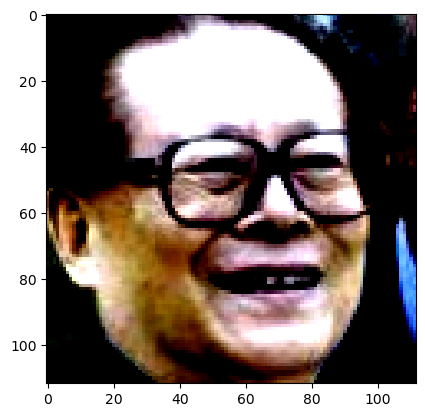

/kaggle/working/lfw_cut/test/Jiang_Zemin/Jiang_Zemin_0002.jpg


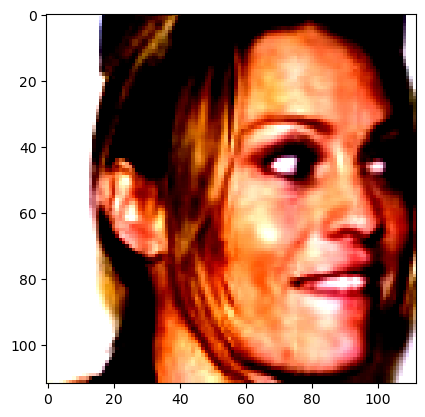

/kaggle/working/lfw_cut/test/Richard_Armitage/Richard_Armitage_0002.jpg


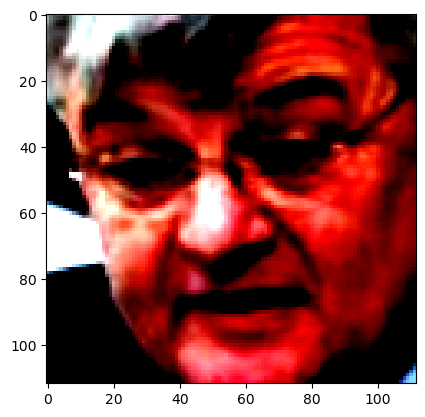

/kaggle/working/lfw_cut/test/Rod_Blagojevich/Rod_Blagojevich_0001.jpg


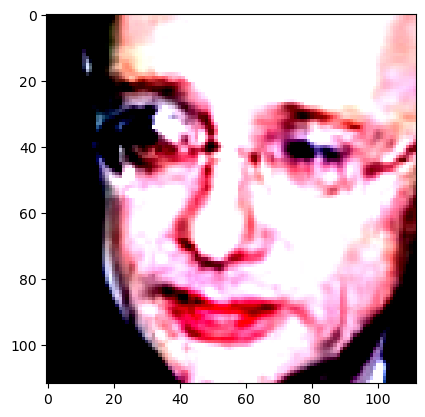

/kaggle/working/lfw_cut/test/Paul_Reiser/Paul_Reiser_0001.jpg


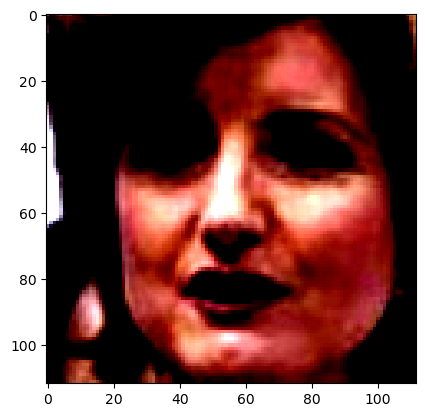

In [16]:
iterate = iter(data_loader_test)
for i in range(5):
    images, labels = next(iterate)
    print(lfwdataset_test.data[labels[0].numpy()])
    # # Display the first image in the batch
    plt.imshow(images[0].permute(1, 2, 0))
    plt.show()

In [17]:
using_ckpt = False
def conv3x3(in_planes, out_planes, stride=1, groups=1, dilation=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes,
                     out_planes,
                     kernel_size=3,
                     stride=stride,
                     padding=dilation,
                     groups=groups,
                     bias=False,
                     dilation=dilation)


def conv1x1(in_planes, out_planes, stride=1):
    """1x1 convolution"""
    return nn.Conv2d(in_planes,
                     out_planes,
                     kernel_size=1,
                     stride=stride,
                     bias=False)


class IBasicBlock(nn.Module):
    expansion = 1
    def __init__(self, inplanes, planes, stride=1, downsample=None,
                 groups=1, base_width=64, dilation=1):
        super(IBasicBlock, self).__init__()
        if groups != 1 or base_width != 64:
            raise ValueError('BasicBlock only supports groups=1 and base_width=64')
        if dilation > 1:
            raise NotImplementedError("Dilation > 1 not supported in BasicBlock")
        self.bn1 = nn.BatchNorm2d(inplanes, eps=1e-05,)
        self.conv1 = conv3x3(inplanes, planes)
        self.bn2 = nn.BatchNorm2d(planes, eps=1e-05,)
        self.prelu = nn.PReLU(planes)
        self.conv2 = conv3x3(planes, planes, stride)
        self.bn3 = nn.BatchNorm2d(planes, eps=1e-05,)
        self.downsample = downsample
        self.stride = stride

    def forward_impl(self, x):
        identity = x
        out = self.bn1(x)
        out = self.conv1(out)
        out = self.bn2(out)
        out = self.prelu(out)
        out = self.conv2(out)
        out = self.bn3(out)
        if self.downsample is not None:
            identity = self.downsample(x)
        out += identity
        return out        

    def forward(self, x):
        if self.training and using_ckpt:
            return checkpoint(self.forward_impl, x)
        else:
            return self.forward_impl(x)


class IResNet(nn.Module):
    fc_scale = 7 * 7
    def __init__(self,
                 block, layers, dropout=0.5, num_features=512, zero_init_residual=False,
                 groups=1, width_per_group=64, replace_stride_with_dilation=None, fp16=False):
        super(IResNet, self).__init__()
        self.extra_gflops = 0.0
        self.fp16 = fp16
        self.inplanes = 64
        self.dilation = 1
        if replace_stride_with_dilation is None:
            replace_stride_with_dilation = [False, False, False]
        if len(replace_stride_with_dilation) != 3:
            raise ValueError("replace_stride_with_dilation should be None "
                             "or a 3-element tuple, got {}".format(replace_stride_with_dilation))
        self.groups = groups
        self.base_width = width_per_group
        self.conv1 = nn.Conv2d(3, self.inplanes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(self.inplanes, eps=1e-05)
        self.prelu = nn.PReLU(self.inplanes)
        self.layer1 = self._make_layer(block, 64, layers[0], stride=2)
        self.layer2 = self._make_layer(block,
                                       128,
                                       layers[1],
                                       stride=2,
                                       dilate=replace_stride_with_dilation[0])
        self.layer3 = self._make_layer(block,
                                       256,
                                       layers[2],
                                       stride=2,
                                       dilate=replace_stride_with_dilation[1])
        self.layer4 = self._make_layer(block,
                                       512,
                                       layers[3],
                                       stride=2,
                                       dilate=replace_stride_with_dilation[2])
        self.bn2 = nn.BatchNorm2d(512 * block.expansion, eps=1e-05,)
        self.dropout = nn.Dropout(p=dropout, inplace=True)
        self.fc = nn.Linear(512 * block.expansion * self.fc_scale, num_features)
        self.features = nn.BatchNorm1d(num_features, eps=1e-05)
        nn.init.constant_(self.features.weight, 1.0)
        self.features.weight.requires_grad = False

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.normal_(m.weight, 0, 0.1)
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, IBasicBlock):
                    nn.init.constant_(m.bn2.weight, 0)

    def _make_layer(self, block, planes, blocks, stride=1, dilate=False):
        downsample = None
        previous_dilation = self.dilation
        if dilate:
            self.dilation *= stride
            stride = 1
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride),
                nn.BatchNorm2d(planes * block.expansion, eps=1e-05, ),
            )
        layers = []
        layers.append(
            block(self.inplanes, planes, stride, downsample, self.groups,
                  self.base_width, previous_dilation))
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(
                block(self.inplanes,
                      planes,
                      groups=self.groups,
                      base_width=self.base_width,
                      dilation=self.dilation))

        return nn.Sequential(*layers)

    def forward(self, x):
        with torch.cuda.amp.autocast(self.fp16):
            x = self.conv1(x)
            x = self.bn1(x)
            x = self.prelu(x)
            x = self.layer1(x)
            x = self.layer2(x)
            x = self.layer3(x)
            x = self.layer4(x)
            x = self.bn2(x)
            x = torch.flatten(x, 1)
            x = self.dropout(x)
        x = self.fc(x.float() if self.fp16 else x)
        x = self.features(x)
        return x


def _iresnet(arch, block, layers, pretrained, progress, **kwargs):
    model = IResNet(block, layers, **kwargs)
    if pretrained:
        raise ValueError()
    return model


def iresnet18(pretrained=False, progress=True, **kwargs):
    return _iresnet('iresnet18', IBasicBlock, [2, 2, 2, 2], pretrained,
                    progress, **kwargs)


def iresnet34(pretrained=False, progress=True, **kwargs):
    return _iresnet('iresnet34', IBasicBlock, [3, 4, 6, 3], pretrained,
                    progress, **kwargs)


def iresnet50(pretrained=False, progress=True, **kwargs):
    return _iresnet('iresnet50', IBasicBlock, [3, 4, 14, 3], pretrained,
                    progress, **kwargs)

In [18]:
# Path_resnet = Path('/kaggle/input/arcface-weights-13/resnet50_weights2 (3).pth') 
# if (Path_resnet.is_file()):
#     weights = model.ResNet50_Weights.DEFAULT
#     models = model.resnet50(weights= weights)
#     # Freeze All CNN Layers (Stop all learning in all layers)
#     for param in models.parameters():
#         param.requires_grad = False

#     # Change the final layer (unfreeze fc layer)
#     models.avgpool = torch.nn.Identity()
#     models.fc = torch.nn.Sequential(
#     torch.nn.BatchNorm1d(num_features= 32768),
#     torch.nn.Dropout(p=0.5),
#     torch.nn.Linear(in_features= 32768, out_features=512, bias=True),
#     torch.nn.BatchNorm1d(num_features=512)
#     )
#     models.fc.requires_grad = True
#     models = DataParallel(models)
#     models.load_state_dict(torch.load('/kaggle/input/arcface-weights-13/resnet50_weights2 (3).pth'))
#     print(models.state_dict())
# else:
#     weights = model.ResNet50_Weights.DEFAULT
#     models = model.resnet50(weights= weights)

#     # Freeze All CNN Layers (Stop all learning in all layers)
#     for param in models.parameters():
#         param.requires_grad = False

#     # Change the final layer (unfreeze fc layer)
#     models.avgpool = torch.nn.Identity()
#     models.fc = torch.nn.Sequential(
#     torch.nn.BatchNorm1d(num_features= 32768),
#     torch.nn.Dropout(p=0.5),
#     torch.nn.Linear(in_features= 32768, out_features=512, bias=True),
#     torch.nn.BatchNorm1d(num_features=512)
#     )
#     models.fc.requires_grad = True
#     models = DataParallel(models)

# models.to(device)
# models

In [19]:
# import gc
# gc.collect()
# torch.cuda.memory_summary(device=None, abbreviated=False)

In [20]:
#Implemenet CNN Baacosh_ckbone
Path_resnet = Path('/kaggle/input/arcface-weight-m03/resnet50_weights2.pth') 
if (Path_resnet.is_file()):
    models = iresnet50()
    models.fc.requires_grad = True
#     models = DataParallel(models)
    models.load_state_dict(torch.load('/kaggle/input/arcface-weight-m03/resnet50_weights2.pth'))
else:
    models = iresnet50()
    models.fc.requires_grad = True
    # models = DataParallel(models)

models.to(device)
models

IResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (prelu): PReLU(num_parameters=64)
  (layer1): Sequential(
    (0): IBasicBlock(
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (prelu): PReLU(num_parameters=64)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (downsample): Sequential(
        (0): Conv2d(64, 64, kernel_size=(1, 1), stride=(2, 2), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (1): IBas

In [21]:
Path_arcface = Path('/kaggle/input/arcface-weight-m03/arcface_weights2.pth')
# Path_arcface = Path('/kaggle/input/arcface-weights/arcface_weights3.pth')
if (Path_arcface.is_file()):
    metric_fc = ArcFaceLoss(512, num_classes_LFW, 30.0, 0.3)
#     metric_fc = DataParallel(metric_fc)
    metric_fc.requires_grad = True
    metric_fc.load_state_dict(torch.load('/kaggle/input/arcface-weight-m03/arcface_weights2.pth'))
else:
    metric_fc = ArcFaceLoss(512, num_classes_LFW, 30.0, 0.3)
    # metric_fc = DataParallel(metric_fc)
    metric_fc.requires_grad = True

metric_fc.to(device)
print(metric_fc.state_dict())
# Analyze model parameters and layers
#summary(models, (3, 112, 112))

OrderedDict([('weight', tensor([[ 2.7382e-02, -1.2588e-02,  1.0005e-02,  ..., -4.8042e-02,
         -4.1711e-02, -2.2998e-02],
        [-8.5935e-02,  3.7732e-02,  9.5469e-04,  ..., -4.7858e-02,
         -3.6939e-05, -1.9387e-02],
        [-1.2818e-02,  1.4544e-02, -6.3380e-02,  ...,  3.6140e-03,
         -1.2618e-03,  2.7924e-02],
        ...,
        [-2.2644e-02, -6.3954e-02,  3.7708e-02,  ...,  2.4565e-02,
          1.4781e-02, -3.8847e-02],
        [ 3.1558e-02,  6.5153e-02,  2.9573e-02,  ...,  4.7248e-02,
         -2.0165e-02,  6.3889e-03],
        [-4.4279e-02,  6.1476e-02,  9.4149e-02,  ...,  2.0598e-02,
          1.2138e-03,  3.6388e-02]], device='cuda:0'))])


In [22]:
# Focal loss is an improved method of Cross Entropy that can focus on scaling the harder cases then the easier cases
#Loss = torch.nn.CrossEntropyLoss().to(device)
Loss = FocalLoss(gamma= 2).to(device)
Loss.requires_grad = True

In [23]:
# Setup Optimizer and Scheduler
optimizer = torch.optim.SGD([{'params': models.parameters()},
                              {'params': metric_fc.parameters()}],
                              lr = 1e-1, weight_decay= 5e-4, momentum= 0.9)  # Can use Adam or SGD
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones= [30, 80, 120, 170], gamma= 0.1)



In [24]:
# Train Model with Provided ArcFace 
# start = time.time()
# history = []
# best_acc = 0.0


# for epoch in range(50):
#     epoch_start = time.time()
#     print("Epoch: {}/{}".format(epoch + 1, 10))

#     # Set model to train mode
#     models.train()
# #     metric_fc.train()
#   #  Step through scheduler
#     scheduler.step()

#     train_loss = 0.0
#     train_acc = 0.0 

#     valid_loss = 0.0
#     valid_acc = 0.0


#     for i, (images, labels) in enumerate(data_loader_train):
        
#         # Put tensors into device to run CUDA
#         images, labels = images.to(device), labels.to(device)
        
#         # Run Resnet50 on images to compute the embedding of size 512
#         embeddings = models(images)

#         # Push this embedding to our Arcface fc output layer
#         output = metric_fc(embeddings, labels)
        
#         # Calculate loss
#         loss = Loss(output, labels)

#         # Clean existing gradients
#         optimizer.zero_grad()
        
#         # Backprop the gradients
#         loss.backward()

#         # Update Parameters after backprop
#         optimizer.step()
        

#         # Accumulate loss
#         train_loss += loss.item()

#         # Accuracy prediction
#         ret, predictions = torch.max(output.data, 1)
#         correct_counts = predictions.eq(labels.data.view_as(predictions))

#         # Conver correct_counts to float then compute the mean
#         acc = torch.mean(correct_counts.type(torch.FloatTensor))
  
#         # Compute the total accuracy in the whole batch and add to train_acc
#         train_acc += acc.item()
#         if (i % 100 == 0):
#           #print('Predictions: {}, Truth: {}'.format(output, labels))
#             print('Batch #: [{:03d}/{}], Train Loss: {}, Train Accuracy: {}'
#                   .format(i+1, len(data_loader_train), train_loss / (i+1), train_acc / (i + 1)))
      

#     history.append({'loss': train_loss / len(data_loader_train), 'acc': train_acc / len(data_loader_train)})

In [25]:
# Lightning PyTorch Trainer
import pytorch_lightning as L

class LightningArcFace(L.LightningModule):
    def __init__(self):
        super().__init__()
        self.encoder = models
        self.decoder = metric_fc

#         self.encoder = iresnet50()
#         self.decoder = ArcFaceLoss(512, num_classes_LFW, 30.0, 0.3)

    def forward(self, x):
        embedding = self.encoder(x)
        return embedding

    def training_step(self, batch, batch_idx):
        img, label = batch
        embedding = self.encoder(img)
        output = self.decoder(embedding, label)
        loss = Loss(output, label)
        self.log("train_loss", loss, prog_bar= True)
        return loss

    def train_dataloader(self):
        return data_loader_train
    def configure_optimizers(self):
        optimizer = torch.optim.SGD([{'params': self.encoder.parameters()},
                              {'params': self.decoder.parameters()}],
                              lr = 1e-2, weight_decay= 5e-4, momentum= 0.9)  # Can use Adam or SGD
        return optimizer
    def predict_step(self, batch, batch_idx):
        x, y = batch
        emb = self.encoder(x)
        return {'embeddings': emb, 'labels': y}


In [26]:
# Visualize the embedding spaces
def visualize_lightning(trainer, model, loader, title):
    outputs = trainer.predict(model, loader)
    embeddings = F.normalize(torch.cat([output['embeddings'] for output in outputs])).numpy()
#     embeddings = torch.cat([output['embeddings'] for output in outputs]).numpy()
    labels = torch.cat([output['labels'] for output in outputs]).numpy()
    
    colors = ["red", "black", "yellow", "green", "pink",
              "gray", "lightgreen", "orange", "blue", "teal"]

    plt.figure(figsize=(8, 8))
    plt.scatter(embeddings[:,0], embeddings[:,1], 
                color=[colors[label % 10] for label in labels])
    ax = plt.gca()
#     ax.set_xlim([-1.2, 1.2])
#     ax.set_ylim([-1.2, 1.2])
    ax.set_aspect('equal', adjustable='box')
    plt.title(title)
    plt.show()

In [27]:
# Instantiate lightning module
autoencoder = LightningArcFace()
# autoencoder = LightningArcFace.load_from_checkpoint("/kaggle/input/lightning-weight/epoch_40_step_3403.ckpt")
trainer = L.Trainer(accelerator= "cuda", devices= 1, max_epochs= 150, enable_progress_bar= True, enable_checkpointing= True)
trainer.fit(model= autoencoder)

Training: 0it [00:00, ?it/s]

In [28]:
# autoencoder = LightningArcFace.load_from_checkpoint("/kaggle/input/lightning-weight/epoch_40_step_3403.ckpt")
# trainer = L.Trainer(accelerator= "cuda", devices= 1, max_epochs= 100, enable_progress_bar= True, enable_checkpointing= True)

Predicting: 0it [00:00, ?it/s]

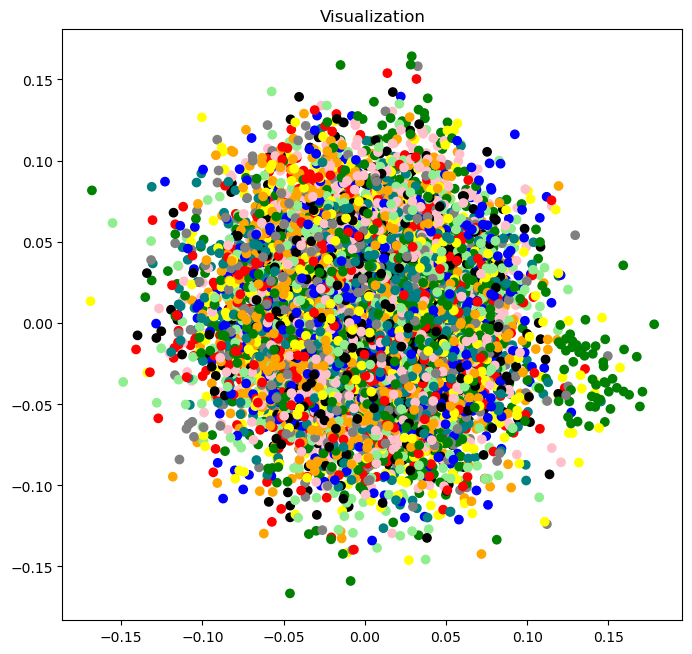

In [29]:
visualize_lightning(trainer, autoencoder, data_loader_train, "Visualization")

In [30]:
models = autoencoder

In [31]:
# Save Weights from metric_fc and resnet50
torch.save(models.state_dict(), '/kaggle/working/resnet50_weights2.pth')
torch.save(metric_fc.state_dict(), '/kaggle/working/arcface_weights2.pth')
print("Weights")

Weights


In [32]:
# Visualize the training and validation results
# accuracy = [res['acc'] for res in history]
# losses = [res['loss'] for res in history]

# fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 5))
# ax1.plot(losses, '-o', label = 'Loss')
# ax1.set_xlabel("Number of Epochs")
# ax1.set_ylabel("Loss")
# ax1.legend()

# ax2.plot(100 * np.array(accuracy), '-o', label = 'Accuracy')
# ax2.set_xlabel("Number of Epochs")
# ax2.set_ylabel("Accuracy")
# ax2.legend();

# fig.show()

In [33]:
# Get the embedding list and label list
models.to(device)
with torch.no_grad():
    models.eval()
    embedding_list = []
    label_list = []
    # Fill query and gallery set
    for i, (img, label) in enumerate(data_loader_valid):
        img, label = img.to(device), label.to(device)
        embeddings = models(img)
        embedding_list.append(embeddings)
        label_list.append(label)

    label_list = torch.cat(label_list)
    embedding_list = torch.cat(embedding_list)
    

In [34]:
# with torch.no_grad():
#     models.eval()
#     embedding_list = []
#     label_list = []
#     for idx, img_path in enumerate(lfwdataset_test.data):
#         img = RetinaFace.extract_faces(img_path, align= True)
#         img = Image.fromarray(img[0])
#         img = img.convert("RGB")
#         img = transform(img)
        
#         _,label = lfwdataset_test[idx]
#         #img, label = img.to(device), label.to(device)
#         img = img.to(device)
#         img = torch.unsqueeze(img, dim= 0)
#         embeddings = models(img)
#         embedding_list.append(embeddings)
#         label_list.append(label)
        

In [35]:
# Make class dictionary
class_dict = {}
label_list = label_list.to("cpu").numpy().tolist()
for i in range(len(label_list)):
    if (label_list[i] not in class_dict):
        class_dict[label_list[i]] = [embedding_list[i]]
    else:
        class_dict[label_list[i]].append(embedding_list[i])


In [36]:
for label in class_dict.keys():
    class_dict[label] = torch.stack(class_dict[label])

In [37]:
print(class_dict[20][0].shape)

torch.Size([512])


In [38]:
# Fill query and gallery sets
query_set = {"embedding": [],
            "label": []}
gallery_set = {"embedding": [],
            "label": []}
for label in class_dict.keys():
    if (len(class_dict[label]) > 1):
        query_set["embedding"].append(class_dict[label][0])
        query_set["label"].append(label)
        
        for j in range(1, len(class_dict[label])):
            gallery_set["embedding"].append(class_dict[label][j])
            gallery_set["label"].append(label)

In [39]:
gallery_set["embedding"] = torch.stack(gallery_set["embedding"])
label_dict = {}
for idx in range(len(gallery_set["label"])):
    label_dict[idx] = gallery_set["label"][idx]
gallery_set["label"] = label_dict
print(len(gallery_set["label"]))
print(len(query_set["embedding"]))
print(gallery_set["embedding"].shape)
print(query_set["embedding"][0].shape)

632
159
torch.Size([632, 512])
torch.Size([512])


In [40]:
# # Probe images to test against the embedding gallery
# with torch.inference_mode():
#     models.eval()

#     correct_counts1 = 0.0
#     correct_counts2 = 0.0
#     correct_counts3 = 0.0

#     for probe_idx in range(len(query_set['embedding'])):
#         probe_emb = query_set['embedding'][probe_idx]
#         probe_label = query_set['label'][probe_idx]

#         # cos_similarity = torch.matmul(probe_emb, gallery['embeddings'].transpose(0, 1))

#         cos_similarity = F.cosine_similarity(probe_emb, gallery_set['embedding'], dim= -1)
#        # print(cos_similarity)
# #         print('Cosine Sim: {}, {}'.format(probe_label, cos_similarity[probe_label]))
#         #print('probe label:{}'.format(probe_label))
#         ret, pred = torch.topk(cos_similarity, 3)
#         #print(ret, gallery_set['label'][pred[0].to("cpu").numpy().tolist()], gallery_set['label'][pred[1].to("cpu").numpy().tolist()], gallery_set['label'][pred[2].to("cpu").numpy().tolist()])
#         #print('prediction: {}, {}'.format(ret, gallery_set['label'][pred.to("cpu").numpy().tolist()]))
#         #correct_counts += torch.eq(probe_label, gallery_set['label'][pred.to("cpu").numpy().tolist()])
#       #  correct_counts += torch.sum(torch.eq(probe_label, gallery_set['label'][pred]))
#         correct_counts1 +=  gallery_set['label'][pred[0].to("cpu").numpy().tolist()] == probe_label
#         correct_counts2 +=  (gallery_set['label'][pred[0].to("cpu").numpy().tolist()] == probe_label) or (gallery_set['label'][pred[1].to("cpu").numpy().tolist()] == probe_label)
#         correct_counts3 +=  (gallery_set['label'][pred[0].to("cpu").numpy().tolist()] == probe_label) or (gallery_set['label'][pred[1].to("cpu").numpy().tolist()] == probe_label) or (gallery_set['label'][pred[2].to("cpu").numpy().tolist()] == probe_label)
# top_1 = correct_counts1 / len(query_set["embedding"])
# top_2 = correct_counts2 / len(query_set["embedding"]) 
# top_3 = correct_counts3 / len(query_set["embedding"])   
# print('top 1 accuracy: {}'.format(top_1))
# print('top 2 accuracy: {}'.format(top_2))
# print('top 3 accuracy: {}'.format(top_3))
# print(gallery_set["label"])

Rank 1 Accuracy: 0.2893081761006289, Rank 5 Accuracy: 0.49056603773584906


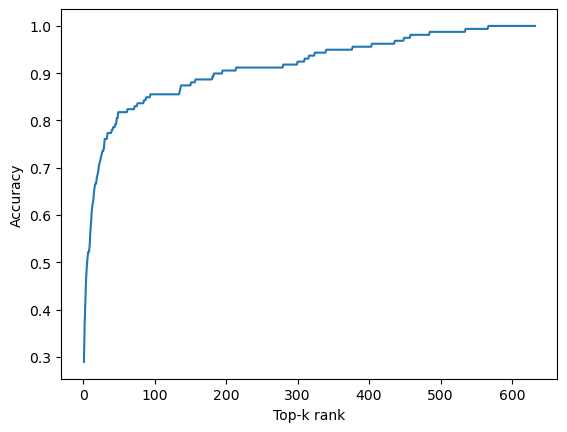

In [41]:
# Probe images to test against the embedding gallery
with torch.inference_mode():
    models.eval()
    correct_counts = [0.0] * len(gallery_set["label"])
    total_counts = [0.0] * len(gallery_set["label"])
    top_k_accuracy = [0.0] * len(gallery_set["label"])

    for probe_idx in range(len(query_set['embedding'])):
        probe_emb = query_set['embedding'][probe_idx]
        probe_label = query_set['label'][probe_idx]
        cos_similarity = F.cosine_similarity(probe_emb, gallery_set['embedding'], dim= -1)

        # Iterate over all values of k
        for k in range(1, len(gallery_set["label"]) + 1):
            ret, pred = torch.topk(cos_similarity, k)
#             print(ret, pred)
            # Compute accuracy for this value of k
            correct_counts[k-1] += int(any(probe_label == gallery_set['label'][i] for i in pred.to("cpu").numpy().tolist()[:k]))
            total_counts[k-1] += 1
            top_k_accuracy[k-1] = correct_counts[k-1] / total_counts[k-1]

# Plot the accuracy vs top-k rank
import matplotlib.pyplot as plt
print("Rank 1 Accuracy: {}, Rank 5 Accuracy: {}".format(top_k_accuracy[0], top_k_accuracy[4]))
plt.plot(range(1, len(top_k_accuracy)+1), top_k_accuracy)
plt.xlabel('Top-k rank')
plt.ylabel('Accuracy')
plt.show()

In [42]:
# Face Verification 
# from deepface import DeepFace
# correct_counts = 0.0
# y_true = []
# cos_list = []
# for idx, (img1, img2) in enumerate(lfw_pairs_test.data):
#     obj = DeepFace.verify(img1, img2
#           , model_name = 'ArcFace', detector_backend = 'retinaface')
#     _, _, label = lfw_pairs_test[idx]
#     y_true.append(label)
#     cos_list.append(1 - obj['distance'])
#     correct_counts += (label == 1) == obj['verified']
#     print('Cosine Similarity: {}, Prediction: {}, Label: {}'.format(1 - obj['distance'], obj['verified'], label == 1))
# print(correct_counts / len(lfw_pairs_test.data))

retinaface.h5 will be downloaded from the url https://github.com/serengil/deepface_models/releases/download/v1.0/retinaface.h5


Downloading...
From: https://github.com/serengil/deepface_models/releases/download/v1.0/retinaface.h5
To: /root/.deepface/weights/retinaface.h5
100%|██████████| 119M/119M [00:00<00:00, 145MB/s]


torch.Size([3, 112, 112])
torch.Size([3, 112, 112])


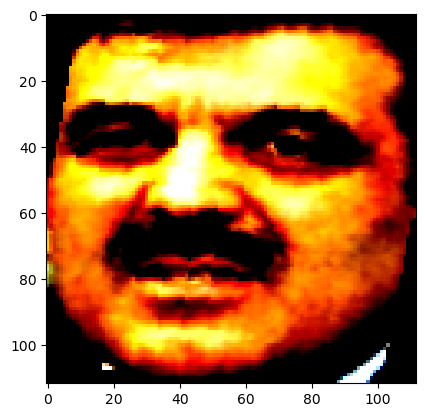

In [43]:
img1_path, img2_path = lfw_pairs_test.data[0]
img1 = RetinaFace.extract_faces(img1_path, align= True)
img2 = RetinaFace.extract_faces(img2_path, align= True)
img1 = Image.fromarray(img1[0])
img2 = Image.fromarray(img2[0])
img1 = img1.convert("RGB")
img2 = img2.convert("RGB")
img1 = transform(img1)
img2 = transform(img2)
img1_ex, label = lfwdataset_test[0]
print(img1_ex.shape)
print(img1.shape)
plt.imshow(img1.permute(1,2,0))

In [44]:
# for idx, (img1_path, img2_path) in enumerate(lfw_pairs_test.data):
# #         print(idx)
#         img = cv2.imread(img1_path)
#         print(img.shape)
#         img1 = RetinaFace.extract_faces(img1_path, align= True, allow_upscaling= True)
#         img2 = RetinaFace.extract_faces(img2_path, align= True, allow_upscaling= True)
        
#         fig = plt.figure()
#         for face in img1:
#             print("first image")
#             plt.imshow(face)
#             plt.show()
#         for face in img2:
#             print("second image")
#             plt.imshow(face)
#             plt.show()

In [45]:
# Evaluate against my model 
with torch.inference_mode():
    correct_count = 0.0
    models.to("cpu")
    models.eval()
    metric_fc.eval()
    y_true = []
    y_pred = []
    cos_list_same = []
    cos_list_diff = []
    cos_list = []
    for idx, (img1, img2, label) in enumerate(lfw_pairs_test):
        
        # Do Face Detection Alignment
        img1_path, img2_path = lfw_pairs_test.data[idx]
        faces1 = RetinaFace.extract_faces(img1_path, align= True, allow_upscaling= True)
        faces2 = RetinaFace.extract_faces(img2_path, align= True, allow_upscaling= True)
        
        max_cos_sim = float('-inf')
        # Find the most prominent matches in the images
        for i in range(len(faces1)):
            img1 = Image.fromarray(faces1[i])
            img1 = img1.convert("RGB")
            img1 = transform(img1)
            
            img1.to(device)
            img1 = torch.unsqueeze(img1, dim= 0)
            embed_1 = models(img1)
            
            for j in range(len(faces2)):
                img2 = Image.fromarray(faces2[j])
                img2 = img2.convert("RGB")
                img2 = transform(img2)

                img2.to(device)
                img2 = torch.unsqueeze(img2, dim= 0)
                embed_2 = models(img2)
                face_cos_sim = F.cosine_similarity(embed_1, embed_2)
                if (face_cos_sim > max_cos_sim):
                    max_cos_sim = face_cos_sim
                    main_img1 = faces1[i]
                    main_img2 = faces2[j]
                    
        cos_sim = max_cos_sim
        cos_list.append(cos_sim.to("cpu"))
        if (label == 1):
            cos_list_same.append(cos_sim.to("cpu"))
        else:
            cos_list_diff.append(cos_sim.to("cpu"))
            
        print('Cosine Similarity: {}, Prediction: {}, Ground Truth: {}'.format(cos_sim.to("cpu").numpy()[0], cos_sim.to("cpu").numpy()[0] > 0.313, label))
        correct_count += label == (cos_sim.to("cpu").numpy()[0] > 0.313)
        
        # Add labels and predictions
        y_true.append(label)
        y_pred.append(cos_sim.to("cpu").numpy()[0] > 0.313)

    print(correct_count / len(lfw_pairs_test))

Cosine Similarity: 0.6873786449432373, Prediction: True, Ground Truth: 1
Cosine Similarity: 0.5626956820487976, Prediction: True, Ground Truth: 1
Cosine Similarity: 0.26854991912841797, Prediction: False, Ground Truth: 1
Cosine Similarity: 0.5333077907562256, Prediction: True, Ground Truth: 1
Cosine Similarity: 0.15678580105304718, Prediction: False, Ground Truth: 1
Cosine Similarity: 0.40003883838653564, Prediction: True, Ground Truth: 1
Cosine Similarity: 0.7006670832633972, Prediction: True, Ground Truth: 1
Cosine Similarity: 0.5571448802947998, Prediction: True, Ground Truth: 1
Cosine Similarity: 0.5718328356742859, Prediction: True, Ground Truth: 1
Cosine Similarity: 0.26952290534973145, Prediction: False, Ground Truth: 1
Cosine Similarity: 0.6334993243217468, Prediction: True, Ground Truth: 1
Cosine Similarity: 0.3327520787715912, Prediction: True, Ground Truth: 1
Cosine Similarity: 0.07664277404546738, Prediction: False, Ground Truth: 1
Cosine Similarity: 0.45750147104263306, Pr

In [46]:
# # Evaluate against my model 
# with torch.inference_mode():
#     correct_count = 0.0
#     models.eval()
#     metric_fc.eval()
#     y_true = []
#     y_pred = []
#     cos_list_same = []
#     cos_list_diff = []
#     cos_list = []
#     for idx, (img1, img2, label) in enumerate(lfw_pairs_test):
        
#         # Do Face Detection Alignment
#         img1_path, img2_path = lfw_pairs_test.data[idx]
#         faces1 = RetinaFace.extract_faces(img1_path, align= True, allow_upscaling= True)
#         faces2 = RetinaFace.extract_faces(img2_path, align= True, allow_upscaling= True)

# #         fig = plt.figure()
# #         ax1 = fig.add_subplot(2, 2, 1)
# #         ax1.imshow(img1[0])
# #         ax2 = fig.add_subplot(2, 2, 2)
# #         ax2.imshow(img2[0])
# #         plt.show()

#         img1 = Image.fromarray(faces1[0])
#         img2 = Image.fromarray(faces2[0])
        
# #         fig = plt.figure()
# #         ax1 = fig.add_subplot(2, 2, 1)
# #         ax1.imshow(img1)
# #         ax2 = fig.add_subplot(2, 2, 2)
# #         ax2.imshow(img2)
# #         plt.show()
        
#         img1 = img1.convert("RGB")
#         img2 = img2.convert("RGB")
#         img1 = transform(img1)
#         img2 = transform(img2)
        
        
#         # Convert images to cuda
#         img1, img2 = img1.to(device), img2.to(device)
#         img1 = torch.unsqueeze(img1, dim= 0)
#         img2 = torch.unsqueeze(img2, dim= 0)
#         #print(img1.shape)
#         embed_1 = models(img1)
#         embed_2 = models(img2)
#         cos_sim = F.cosine_similarity(embed_1, embed_2)
#         cos_list.append(cos_sim.to("cpu"))
#         if (label == 1):
#             cos_list_same.append(cos_sim.to("cpu"))
#         else:
#             cos_list_diff.append(cos_sim.to("cpu"))
            
#         print('Cosine Similarity: {}, Prediction: {}, Ground Truth: {}'.format(cos_sim.to("cpu").numpy()[0], cos_sim.to("cpu").numpy()[0] > 0.20, label))
#         correct_count += label == (cos_sim.to("cpu").numpy()[0] > 0.20)
        
#         # Add labels and predictions
#         y_true.append(label)
#         y_pred.append(cos_sim.to("cpu").numpy()[0] > 0.20)
#         fig = plt.figure()
#         ax1 = fig.add_subplot(2, 2, 1)
#         ax1.imshow(img1[0].to("cpu").permute(1,2,0))
#         ax2 = fig.add_subplot(2, 2, 2)
#         ax2.imshow(img2[0].to("cpu").permute(1,2,0))
#         plt.show()
#     print(correct_count / len(lfw_pairs_test))

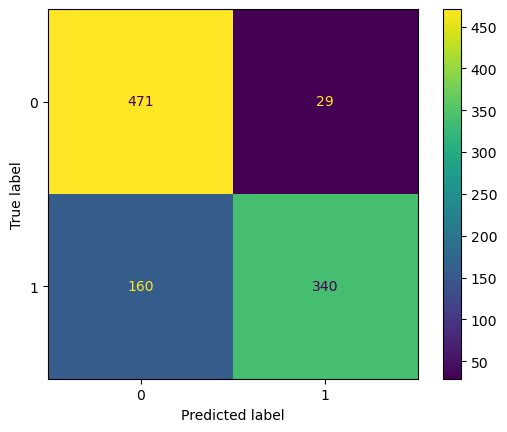

In [47]:
# Make Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

# Display Matrix
cm_display = ConfusionMatrixDisplay(cm).plot()

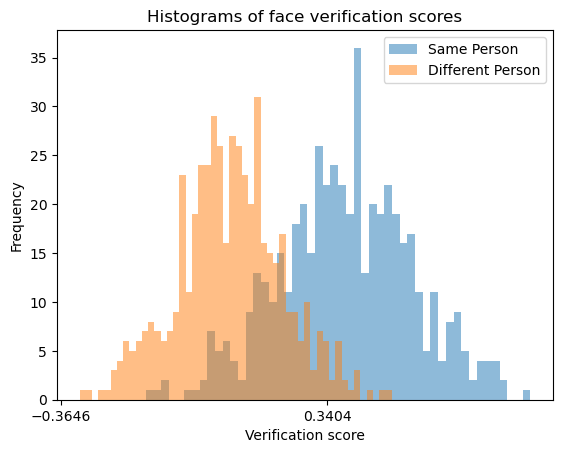

In [48]:
verification_scores_same = np.array([score.item() for score in cos_list_same])
verification_scores_diff = np.array([score.item() for score in cos_list_diff])
verification_scores = np.array([score.item() for score in cos_list])


# Create histograms
plt.hist(verification_scores_same, bins=50, alpha=0.5, label='Same Person')
plt.hist(verification_scores_diff, bins=50, alpha=0.5, label='Different Person')

# Add legend, labels, and title
plt.legend(loc='upper right')
plt.xlabel('Verification score')
plt.ylabel('Frequency')
plt.title('Histograms of face verification scores')
plt.xticks(np.arange(min(min(verification_scores_same), min(verification_scores_diff)) - 0.05, max(max(verification_scores_same), max(verification_scores_diff)) + .05 , .705))
# Show the plot
plt.show()

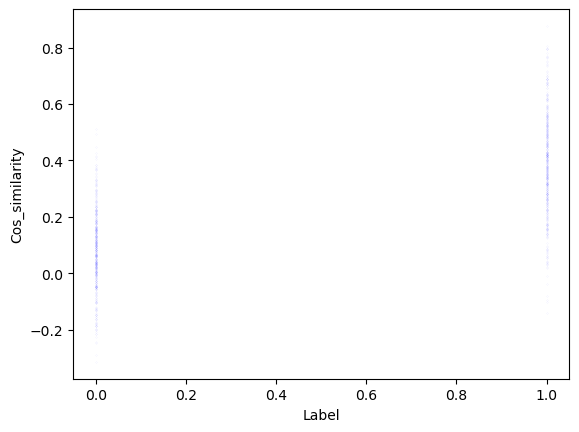

In [49]:
# Make Graph and Histogram of Data Distributions
plt.plot(y_true, cos_list, 'bo', markersize=.018)
plt.ylabel('Cos_similarity')
plt.xlabel('Label')
plt.show()

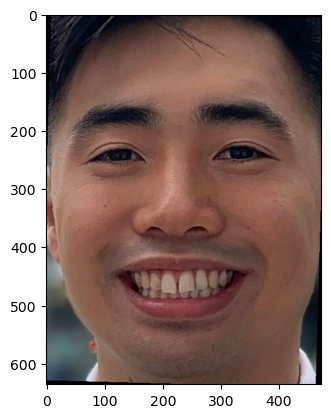

torch.Size([3, 112, 112])
torch.Size([3, 112, 112])


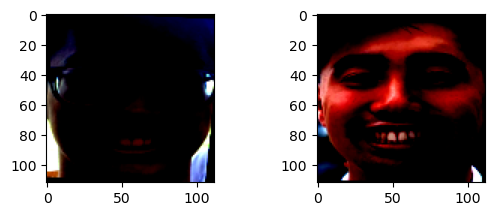

arcface_weights.h5  will be downloaded to  /root/.deepface/weights/arcface_weights.h5


Downloading...
From: https://github.com/serengil/deepface_models/releases/download/v1.0/arcface_weights.h5
To: /root/.deepface/weights/arcface_weights.h5
100%|██████████| 137M/137M [00:01<00:00, 89.5MB/s]


DeepFace Result: 0.28565421496219057
My Model: tensor([0.3388], device='cuda:0', grad_fn=<SumBackward1>)


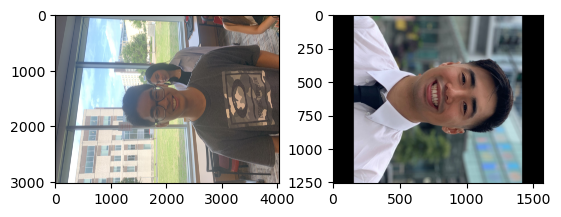

In [50]:
from deepface import DeepFace
models.eval()
models.to(device)
Carter_Pic1_Path = "/kaggle/input/tyler-face/IMG_5113.jpg"
Carter_Pic2_Path = "/kaggle/input/carter-verification/Badge_pic.jpeg"
Carter_Pic1 = RetinaFace.extract_faces(Carter_Pic1_Path, align= True)
Carter_Pic2 = RetinaFace.extract_faces(Carter_Pic2_Path, align= True)
plt.imshow(Carter_Pic2[0])
plt.show()
Carter_Pic1 = Image.fromarray(Carter_Pic1[0])
Carter_Pic2 = Image.fromarray(Carter_Pic2[0])
Carter_Pic1 = Carter_Pic1.convert("RGB")
Carter_Pic2 = Carter_Pic2.convert("RGB")
Carter_Pic1 = transform(Carter_Pic1)
Carter_Pic2 = transform(Carter_Pic2)

print(Carter_Pic1.shape)
print(Carter_Pic2.shape)

# Carter_Pic1 = Image.open('/kaggle/input/carter-verification/Carter_Pic.jpeg')
# Carter_Pic2 = Image.open('/kaggle/input/carter-verification/Badge_pic.jpeg')
# Carter_Pic1 = transform(Carter_Pic1)
# Carter_Pic2 = transform(Carter_Pic2)

fig = plt.figure()
ax1 = fig.add_subplot(2, 2, 1)
ax1.imshow(Carter_Pic1.permute(1,2,0))
ax2 = fig.add_subplot(2, 2, 2)
ax2.imshow(Carter_Pic2.permute(1,2,0))
plt.show()


Carter_Pic1, Carter_Pic2 = Carter_Pic1.to(device), Carter_Pic2.to(device)
Carter_Pic1 = torch.unsqueeze(Carter_Pic1, dim= 0)
Carter_Pic2 = torch.unsqueeze(Carter_Pic2, dim= 0)
emb_1 = models(Carter_Pic1)
emb_2 = models(Carter_Pic2)
cosine_sim = F.cosine_similarity(emb_1, emb_2)
obj = DeepFace.verify(Carter_Pic1_Path, Carter_Pic2_Path
          , model_name = 'ArcFace', detector_backend = 'retinaface')
print('DeepFace Result: {}'.format(1 - obj['distance']))
print('My Model: {}'.format(cosine_sim))
Img_T1 = Image.open("/kaggle/input/tyler-face/IMG_5113.jpg")
Img_T2 = Image.open("/kaggle/input/carter-verification/Badge_pic.jpeg")
fig = plt.figure()
ax1 = fig.add_subplot(2, 2, 1)
ax1.imshow(Img_T1)
ax2 = fig.add_subplot(2, 2, 2)
ax2.imshow(Img_T2.rotate(270))
plt.show()



In [51]:
# Inference Testing
# with torch.no_grad():
#         print("Run Testing Set:")
#         # Set to evaluation mode
#         models.eval()
#         metric_fc.eval()
#         test_loss = 0.0
#         test_acc = 0.0

#         for j, (images, labels) in enumerate(data_loader_test):
#             # Put tensors into device to run CUDA
#             images, labels = images.to(device), labels.to(device)

#             # Run Resnet50 on images to compute the output feature
#             embeddings = models(images)

#             # Push this embedding to our Arcface fc output layer
#             output = metric_fc(embeddings)
            
#             # Calculate loss
#             loss = Loss(output, labels)

#             # Calculate the total loss for the batch and add it to valid_loss
#             test_loss += loss.item()

#             # Accuracy prediction
#             ret, predictions = torch.max(output.data, 1)
#             correct_counts = predictions.eq(labels.data.view_as(predictions))

#             # Convert correct_counts to float then compute the mean
#             acc = torch.mean(correct_counts.type(torch.FloatTensor))

#             # Compute the total accuracy in the whole batch and add to train_acc
#             test_acc += acc.item()
#             if (j % 5 == 0):
#               print('Validation Batch #: {:03d}, Train Loss: {}, Accuracy: {}'
#               .format(j+1, test_loss / (j + 1), test_acc / (j + 1)))
